In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import itertools
import ProjectPacks as pp
%matplotlib inline

from IPython.display import HTML 
HTML('../style/course.css') #apply general CSS

from scipy.optimize import leastsq
plt.rcParams['figure.figsize'] = (18, 6)  #spreads out plot surface for better visualization

from IPython.display import HTML
HTML('../style/code_toggle.html')

In [3]:
def modfunc(x, u_ant, v_ant):
    """
    Returns a vector containing the values of a 3x3 model exponential matrix with source parameters A0,l0,m0.
    
    INPUTS:
    x               Vector of source parameters.  Amp,l,m= x[0],x[1],x[2]  
    u_ant, v_ant    Value of (u,v)baseline measurements at the sampled (timeslot) points.
    """

    Amp= x[0]
    l= x[1]
    m= x[2]
    
    model= Amp*np.exp(-2j*np.pi*(u_ant*l+v_ant*m))
    
    model_stream= np.asarray(list(itertools.chain(model[0,1,:], model[0,2,:], model[1,2,:])),dtype=np.complex128)
    ## baseline (1,2), (1,3), and (2,3) with t timeslots each
    return model_stream.T

In [4]:
def modfunc_jac(x,u_ant,v_ant):
    """
    Returns the Hessian and Jacobian corresponding to the function defined by model equation.
    
    INPUTS:
    x               Vector of source parameters.  A,l,m= x[0],x[1],x[2] 
    u_ant, v_ant    Value of (u,v)baseline measurements at the sampled (timeslot) points. use this as a loop
   
    """
    t= u_ant.shape[2]
    Amp= x[0]
    l= x[1]
    m= x[2]
    
    ## Calculating JHJ explicitly from J
    Psi= 2j*np.pi*(u_ant*l+v_ant*m)
    expPsi= lambda sign: np.exp(sign*Psi)
    
    coeU = -2j*np.pi*Amp*u_ant
    coeV = -2j*np.pi*Amp*v_ant
    ## remember the -(minus) for negative exponents
    
    ## filling up (3,3,300) per baseline row-wise (downwards)
    JkA= np.asarray(list(itertools.chain(expPsi(-1)[0,1,:], expPsi(-1)[0,2,:], expPsi(-1)[1,2,:])),dtype=np.complex128)
    Jkl= np.asarray(list(itertools.chain((coeU*expPsi(-1))[0,1,:], (coeU*expPsi(-1))[0,2,:], (coeU*expPsi(-1))[1,2,:])),
                    dtype=np.complex128)
    Jkm= np.asarray(list(itertools.chain((coeV*expPsi(-1))[0,1,:], (coeV*expPsi(-1))[0,2,:], (coeV*expPsi(-1))[1,2,:])),
                   dtype=np.complex128)
   
    Jk= np.empty((len(JkA),x.shape[0]),dtype=np.complex128)
    
    Jk[:,0]= JkA
    Jk[:,1]= Jkl
    Jk[:,2]= Jkm      
    
    Jh= Jk.conj().T ## Hermitian of J
     
    
    # using Analytic JHJ
    Complete= np.zeros((3,3), dtype=np.complex128)
    for i in range(t):

        U= u_ant[:,:,i]
        V= v_ant[:,:,i]

        sumU,sqsumU= np.sum(np.triu(U,1)),np.sum(np.square(np.triu(U,1)))
        sumV, sqsumV= np.sum(np.triu(V,1)),np.sum(np.square(np.triu(V,1)))
        sumUV= np.sum(np.multiply(np.triu(U,1),np.triu(V,1)))

        ## Packing into Analytic JHJ
        JHJ= np.array([[3, -2j*np.pi*Amp*sumU, -2j*np.pi*Amp*sumV],
                  [2j*np.pi*Amp*sumU, np.square(2*np.pi*Amp)*sqsumU, np.square(2*np.pi*Amp)*sumUV],
                  [2j*np.pi*Amp*sumV, np.square(2*np.pi*Amp)*sumUV, np.square(2*np.pi*Amp)*sqsumV]],dtype=np.complex128)


        Complete += JHJ
    
    return Jh,Complete


In [5]:
def JHJ_computed(x,u_ant,v_ant):
    
    JH = modfunc_jac(x,u_ant,v_ant)[0]
    
    Jk = JH.T.conj()
    JhJ= JH.dot(Jk)
    
    return JhJ

In [6]:
def modfunc_res(x, u_ant, v_ant, data):
    """
    Returns a vector containing the residual values over timeslots.
    
    INPUTS:
    data            Vector of measured values.
    u_ant, v_ant    Value of (u,v)baseline measurements at the sampled (timeslot) points.
    x               Vector of source parameters.  A,l,m= x[0],x[1],x[2]    
    """
    
    residual= data - modfunc(x, u_ant, v_ant)
    
    return residual

In [15]:
## Setting up for test using above function
###################RANDOM_X_CON_M###########################

## Choose number of timeslots
for i in range(2,100,2):
    timeslots= i
    Amp_no,l_no,m_no,ut,vt,SNum,ArNum,arrayHxpos=pp.formatSParams('Array_Profile.txt','Field_Profile.txt',td=timeslots)

    ut= np.array(ut,dtype=np.float64)
    vt= np.array(vt,dtype=np.float64)

    t = np.arange(0, 5, 5/timeslots)          #The points at which we will be taking our "measurements"
    noise = 0.000*np.random.normal(size=(t.shape[0])*len(ut)) #A noise vector used to manufacture "real" measurements.

    x_true = np.array([3., 0.45, 0.5])          #The true (starting) values of our parameter vector (for alg).
    x_con = np.array([4., 0.5, 0.5])
    x_start= x_con.copy()

    d = modfunc(x_true, ut, vt) + noise #Our "observed" data, contructed from our true parameter values and the noise vector.
    m = modfunc(x_con, ut, vt)              #Our fitted function using the initial guess parameters.
    r = modfunc_res(x_con, ut, vt, d)

    jh,jhj = modfunc_jac(x_con,ut,vt)
    JHJ = JHJ_computed(x_con,ut,vt)
    
    print(np.all(jhj==JHJ))
    

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


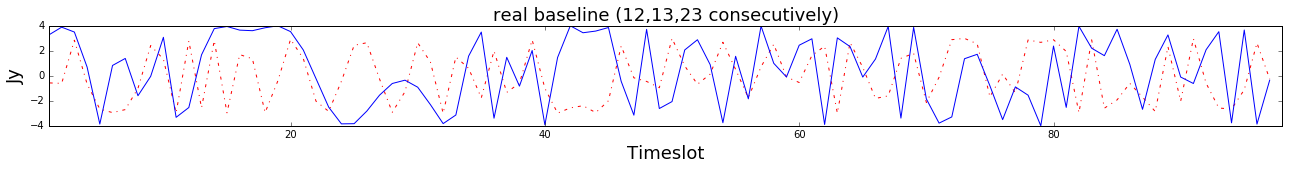

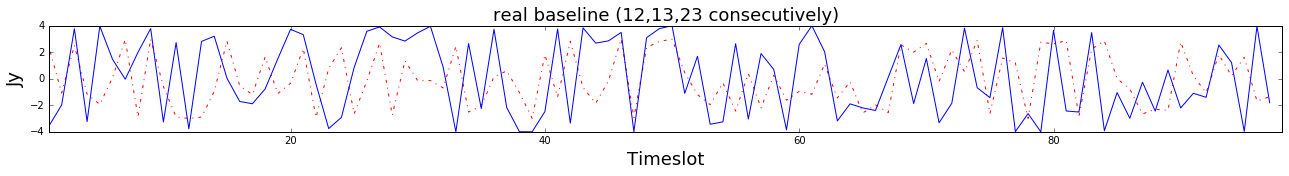

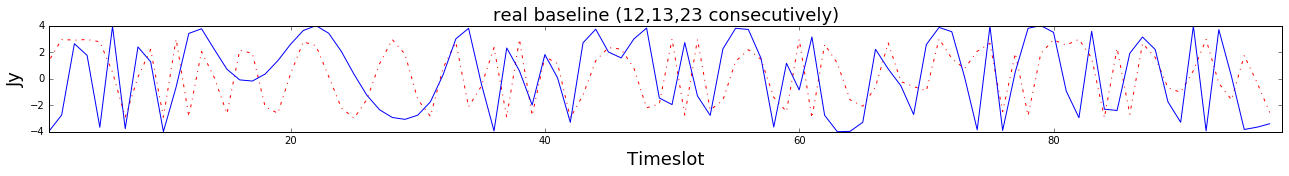

In [8]:
subps=["311","312","312"]

plt.figure()
for j in range(len(ut)):
    ax = plt.subplot(subps[j])
    ax.set_title("real baseline (12,13,23 consecutively)", fontsize=18)
    ax.plot(range(timeslots),d[j*t.shape[0]:(j+1)*t.shape[0]].real,'r-.')
    ax.plot(range(timeslots),m[j*t.shape[0]:(j+1)*t.shape[0]].real)
    ax.set_xlabel("Timeslot", fontsize=18)
    ax.set_ylabel("Jy", fontsize=18)
    ax.set_xlim([1,t.shape[0]])
    y_t = ax.get_yticks()
    y_t = y_t[::2]
    ax.set_yticks(y_t)

    plt.tight_layout()
    plt.show()

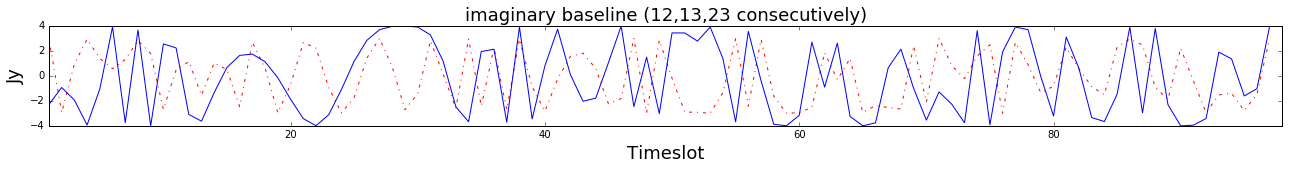

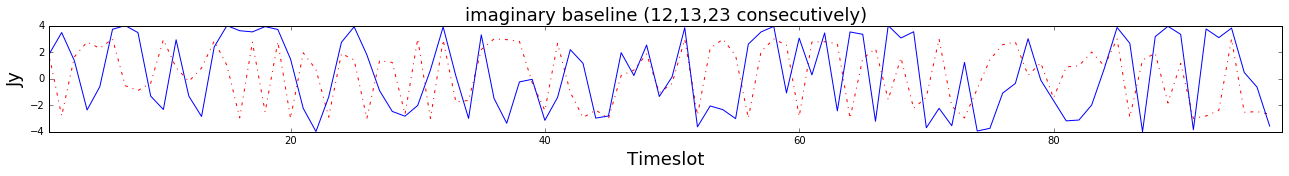

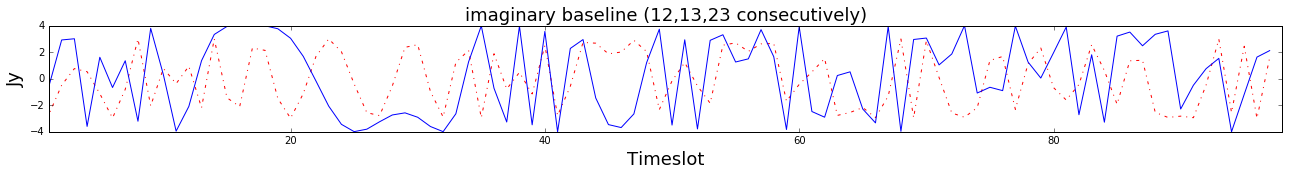

In [9]:
subps=["311","312","312"]

plt.figure()
for j in range(len(ut)):
    ax = plt.subplot(subps[j])
    ax.set_title("imaginary baseline (12,13,23 consecutively)", fontsize=18)
    ax.plot(range(timeslots),d[j*t.shape[0]:(j+1)*t.shape[0]].imag,'r-.')
    ax.plot(range(timeslots),m[j*t.shape[0]:(j+1)*t.shape[0]].imag)
    ax.set_xlabel("Timeslot", fontsize=18)
    ax.set_ylabel("Jy", fontsize=18)
    ax.set_xlim([1,t.shape[0]])
    y_t = ax.get_yticks()
    y_t = y_t[::2]
    ax.set_yticks(y_t)

    plt.tight_layout()
    plt.show()

In [10]:
## trying out real case first
def levenberg_marquardt(data, u_ant, v_ant, x, r_func, j_func, maxit=100, lamda=1, K=10, eps1=1e-6, eps2=1e-6):
    """
    Returns a vector containing the optimal parameter values found by the algorithm.
    
    INPUTS:
    d         Vector of measured values.
    t         Value of independent variable at the sampled points. (300)
    x         Vector of parameters. (1,3)
    r_func    Function which generates the residual vector. (1,900)
    j_func    Function which generates the (Conjugate of) Jacobian & the Hessian. (3,900) & (3,3) 
    maxiter   Maximum number of iterations.
    lamda     Initial value of tuning parameter.
    K         Initial value of retuning factor.
    eps1      First tolerance parameter - triggers when residual is below this number.
    eps2      Second tolerance parameter - triggers when relative changes to the parameter
              vector are below this number.
    """
    x= np.float64(x)
    #Initialises some important values and stores the original lamda value.
    
    r = r_func(x, u_ant, v_ant, data)
    print("Shape of residual vec: ", np.shape(r))
    old_chi = np.linalg.norm(r)
    olamda = lamda
    it = 0
    chiplot=[]
    chiplot.append(old_chi)
    
    while True:
        
        #Heavy lifting portion of the algorithm. Computes the parameter update.
        #This is just the implementation of the mathmatical update rule.
        
        JH,JHJ = j_func(x,u_ant,v_ant)
        JT = JH
        JTJ = JHJ
        
        JTJdiag = np.diag(np.diag(JTJ))
        #this says there is a different D for each timeslot
#         lamda = 1 if (it%2==0) else 0
        JTJinv= np.linalg.pinv(JTJ+lamda*JTJdiag)
        JTr = JT.dot(r)
        
        delta_x = JTJinv.dot(JTr)
        x += delta_x.real
        
        #Convergence tests. If a solution has been found, returns the result.
        #The chi value is the norm of the residual and is used to determine
        #whether the solution is improving. If the chi value is sufficiently 
        #small, the function terminates. The second test checks to see whether
        #or not the solution is improving, and terminates if it isn't.
        
        r = r_func(x, u_ant, v_ant, data)
        new_chi = np.linalg.norm(r)
        chiplot.append(new_chi)
        
        if new_chi < eps1:
            return x,chiplot
        elif np.linalg.norm(delta_x.real) < eps2*(np.linalg.norm(x) + eps2):
            return x,chiplot
        
        #Tuning stage. If the parameter update was good, continue and restore lamda.
        #If the update was bad, scale lamda by K and revert last update.
        
        if new_chi > old_chi:
            x -= delta_x.real
            lamda = lamda*K
        else:
            old_chi = new_chi
            lamda = olamda
            
        #If the number of iterations grows too large, return the last value of x.
        
        it += 1
            
        if it >= maxit:
            return x,chiplot


In [11]:
solved_x,cplot = levenberg_marquardt(d,ut,vt,x_con,modfunc_res,modfunc_jac)
print(solved_x)
print("true x: ", x_true)
print("model x: ",  x_start) #got from up there

Shape of residual vec:  (294,)
[ 0.02154352  0.50018829  0.5       ]
true x:  [ 3.    0.45  0.5 ]
model x:  [ 4.   0.5  0.5]


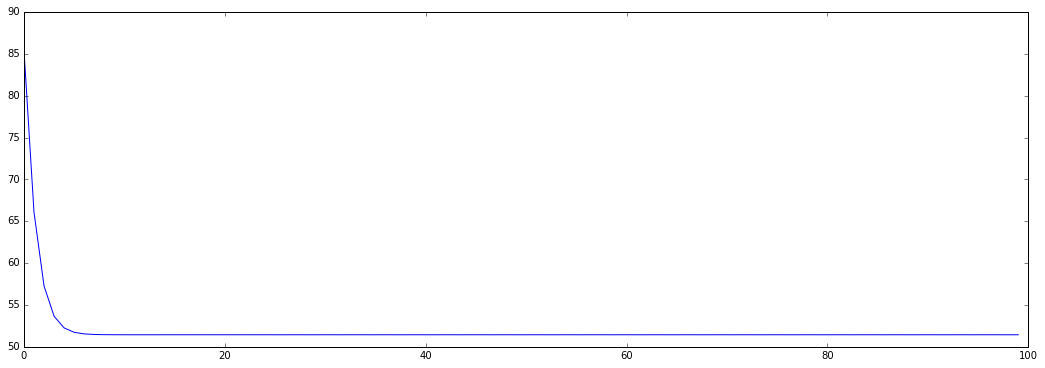

In [12]:
plt.plot(cplot)
plt.show()

TypeError: Length of x must be number of columns in z.

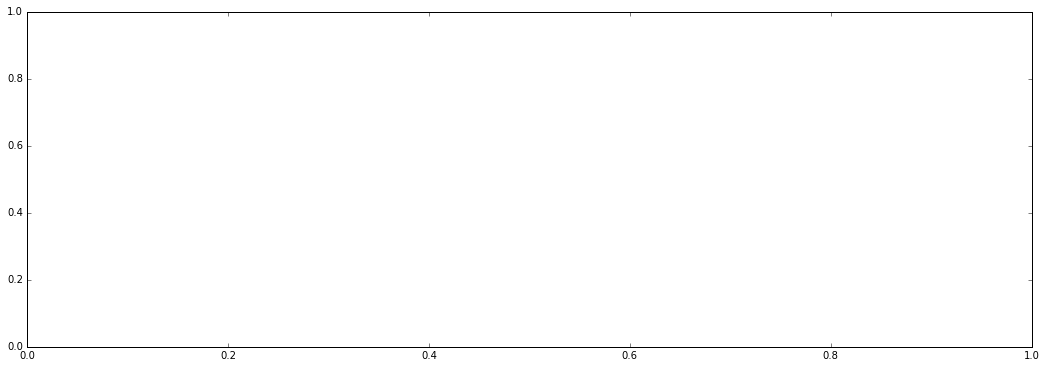

In [13]:
L= np.arange(-1,1,2/timeslots)
M= np.arange(-1,1,2/timeslots)

rr= np.empty((timeslots,timeslots))
for a in range(timeslots):
    for b in range(timeslots):
        x_r= [3,L[a],M[b]]
        rr[a,b]= np.square(np.linalg.norm(modfunc_res(x_r,ut,vt,d)))

obj= plt.contour(L,M,rr,cmap='gray')
plt.xlabel("l_values")
plt.ylabel("m_values")
plt.show()

In [ ]:
#help(plt.contourf)

In [ ]:
subps=["311","312","312"]

plt.figure()
for j in range(len(ut)):
    ax = plt.subplot(subps[j])
    ax.set_title("real baseline (12,13,23 consecutively)", fontsize=18)
    ax.plot(range(timeslots),d[j*t.shape[0]:(j+1)*t.shape[0]].real,'r-.')
    ax.plot(range(timeslots),modfunc(solved_x,ut,vt)[j*t.shape[0]:(j+1)*t.shape[0]].real)
    ax.plot(range(timeslots),modfunc(x_true,ut,vt)[j*t.shape[0]:(j+1)*t.shape[0]].real)
    ax.set_xlabel("Timeslot", fontsize=18)
    ax.set_ylabel("Jy", fontsize=18)
    ax.set_xlim([1,t.shape[0]])
    y_t = ax.get_yticks()
    y_t = y_t[::2]
    ax.set_yticks(y_t)

    plt.tight_layout()
    plt.show()


In [ ]:
# subps=["311","312","312"]

# plt.figure()
# for j in range(len(ut)):
#     ax = plt.subplot(subps[j])
#     ax.set_title("imaginary baseline (12,13,23 consecutively)", fontsize=18)
#     ax.plot(range(timeslots),d[j*t.shape[0]:(j+1)*t.shape[0]].imag,'r-.')
#     ax.plot(range(timeslots),modfunc(solved_x,ut,vt)[j*t.shape[0]:(j+1)*t.shape[0]].imag)
#     ax.plot(range(timeslots),modfunc(x_true,ut,vt)[j*t.shape[0]:(j+1)*t.shape[0]].imag)
#     ax.set_xlabel("Timeslot", fontsize=18)
#     ax.set_ylabel("Jy", fontsize=18)
#     ax.set_xlim([1,t.shape[0]])
#     y_t = ax.get_yticks()
#     y_t = y_t[::2]
#     ax.set_yticks(y_t)

#     plt.tight_layout()
#     plt.show()

In [ ]:
subps=["311","312","312"]

plt.figure()
for j in range(len(ut)):
    ax = plt.subplot(subps[j])
    ax.set_title("real baseline of data and LM (12,13,23 consecutively)", fontsize=18)
    ax.plot(range(timeslots),d[j*t.shape[0]:(j+1)*t.shape[0]].real,'r-.', label="Data")
    ax.plot(range(timeslots),modfunc(solved_x,ut,vt)[j*t.shape[0]:(j+1)*t.shape[0]].real, label='LM')
    ax.set_xlabel("Timeslot", fontsize=18)
    ax.set_ylabel("Jy", fontsize=18)
    ax.set_xlim([1,t.shape[0]])
    y_t = ax.get_yticks()
    y_t = y_t[::2]
    ax.set_yticks(y_t)

    plt.tight_layout()
    plt.show()


In [ ]:
for k in range(ArNum):
    for i in range(k,ArNum):
        plt.plot(ut[k][i],vt[k][i],"r-.", ut[i][k],vt[i][k],"b-")
plt.show()

In [ ]:
print(3*timeslots,-2j*np.pi*x_con[0]*np.sum(ut[0,1,:]+ut[0,2,:]+ut[1,2,:]),
      -2j*np.pi*x_con[0]*np.sum(vt[0,1,:]+vt[0,2,:]+vt[1,2,:]),'\n')
print(2j*np.pi*x_con[0]*np.sum(ut[0,1,:]+ut[0,2,:]+ut[1,2,:]),
      4*np.square(np.pi*x_con[0])*np.sum(ut[0,1,:]*ut[0,1,:]+ut[0,2,:]*ut[0,2,:]+ut[1,2,:]*ut[1,2,:]),
     4*np.square(np.pi*x_con[0])*np.sum(ut[0,1,:]*vt[0,1,:]+ut[0,2,:]*vt[0,2,:]+ut[1,2,:]*vt[1,2,:]),'\n')
print(2j*np.pi*x_con[0]*np.sum(vt[0,1,:]+vt[0,2,:]+vt[1,2,:]),
     4*np.square(np.pi*x_con[0])*np.sum(ut[0,1,:]*vt[0,1,:]+ut[0,2,:]*vt[0,2,:]+ut[1,2,:]*vt[1,2,:]),
     4*np.square(np.pi*x_con[0])*np.sum(vt[0,1,:]*vt[0,1,:]+vt[0,2,:]*vt[0,2,:]+vt[1,2,:]*vt[1,2,:]),)

In [ ]:
# for i in range(0,300,2):
#     timeslots=i
#     print(np.allclose(modfunc_jac1(x_con,ut,vt)[2], modfunc_jac(x_con,ut,vt)[1], rtol=1e-15, atol=1e-15, equal_nan=False),
#           np.allclose(modfunc_jac1(x_con,ut,vt)[1], modfunc_jac(x_con,ut,vt)[1], rtol=1e-15, atol=1e-15, equal_nan=False),
#           np.allclose(modfunc_jac1(x_con,ut,vt)[2], modfunc_jac1(x_con,ut,vt)[1], rtol=1e-15, atol=1e-15, equal_nan=False),
#           np.allclose(modfunc_jac(x_con,ut,vt)[0], modfunc_jac(x_con,ut,vt)[0], rtol=1e-15, atol=1e-15, equal_nan=False))